# Import Packages

In [1]:
import os
import re
import math
import xlsxwriter
import pandas as pd
from pandas import DataFrame
import itertools
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import warnings
os.listdir()

['.ipynb_checkpoints',
 'basisdata waterverbruik.xlsx',
 'Linear Regression Model.ipynb',
 'Paper',
 'Preliminary Analysis.ipynb',
 'README.txt',
 'requirements.txt',
 'Scikit Model Comparison.ipynb',
 'Thesis.rar']

# Parse dataframe, cleaning up weekend/year fraction variables, and combine summer vacation variables

In [2]:
warnings.filterwarnings("ignore")

path = ("basisdata waterverbruik.xlsx")

xl = pd.ExcelFile(path)

df = xl.parse("reinwater SAP")

df['summer-vac'] = np.nan
#year starts at day 1
daycount = 1;
#max day variable
year = 365
df['summer-vac'] = np.nan
df['gelder'] = 0
df['flevo'] = 0
df['utrecht'] = 0
df['fries'] = 0
df['over'] = 0
province = df['provnaam'].iloc[0]
for index, row in df.iterrows():
    #check if its a leap year, then set max day to 366
    if(row['jaar'] % 4 == 0):
        year = 366
    else:
        year = 365
    #reset days if the data switches to the next province
    if(daycount > year):
        daycount = 1
    if(province != row['provnaam']):
        daycount = 1
    
    df.set_value(index,'jaarfractie',daycount/year)
    #only weekends should be set to 1
    if(row['dag'] != 1 and row['dag'] != 7):
        df.set_value(index,'weekend',0)
        df.set_value(index,'doordeweek',1)
    
    province = row['provnaam']
    daycount = daycount + 1
    
    #assign correct summer vacation indicators and dummy encode provinces
    if row['provnaam'] == 'Flevoland' or row['provnaam'] == 'Friesland' or row['provnaam'] == 'Overijssel':
        df.set_value(index,'summer-vac',row['zomer-vakantie noord.1'])
        if row['provnaam'] == 'Flevoland':
            df.set_value(index,'flevo',1)
        if row['provnaam'] == 'Friesland':
            df.set_value(index,'fries',1)
        else:
            df.set_value(index,'over',1)
    if row['provnaam'] == 'Utrecht':
        df.set_value(index,'utrecht',1)
        df.set_value(index,'summer-vac',row['zomer-vakantie midden.1'])
    else:
        df.set_value(index,'gelder',1)
        df.set_value(index,'summer-vac',row['zomer-vakantie zuid.1'])
    

# Setup data for models and run model comparison

In [3]:
#CHANGE PROVINCE NAME HERE options are Utrecht Overijssel Flevoland Friesland Gelderland
consumption_data = df.loc[df['provnaam'] == 'Gelderland']

#select independent vars
x = consumption_data[['jaarfractie','bevolking','summer-vac','tem>20','verd De Bilt','zaagtand','weekdag1','weekdag2','weekdag3','weekdag4','weekdag5','weekdag6']]
y = consumption_data[['tot verbruik']]

#train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#create metrics table
MetricsTable = pd.DataFrame(columns=['Model', 'Mean Absolute Error','Mean Squared Error','Mean Squared Log Error', 'Median Absolute Error','R^2 Score'])

#get name of model only
r1 = re.compile("(.*?)\s*\(")

models =[
            LinearRegression(),
            Ridge(),
            Lasso(),
            ElasticNet(),
            DecisionTreeRegressor(),
            RandomForestRegressor(n_estimators = 100),
            ExtraTreesRegressor(n_estimators = 100),
            GradientBoostingRegressor(max_depth = 5)
]

#param values for finetuning
alphas = np.array([100, 10, 1, 0.1, 0.01, 0.001, 0.0001])
rate = np.array([0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, .5, .6, .7, .8, .9])

#select variables to be tuned for each model
params =[
    {},
    {"alpha":alphas},
    {"alpha":alphas},
    {"alpha":alphas,"l1_ratio":alphas},
    {},
    {},
    {},
    {"loss":["ls","lad","huber","quantile"],"learning_rate":rate}
]

predictions = []

#train and evaluate models
for i in range(0,8):
    model = models[i]
    param_dist = params[i]

    #perform crossvalidation and train model
    pipe = GridSearchCV(model,param_grid=param_dist,cv=5,iid=False)
    models[i] = pipe.fit(X_train, y_train).best_estimator_ 
    
    #predictions on trained model
    prediction = pipe.predict(X_test)
    predictions.append(prediction)
    
    #evaluation metrics
    mae = mean_absolute_error(y_test,prediction)
    mse = mean_squared_error(y_test,prediction)
    msle = mean_squared_log_error(y_test,prediction)
    med = median_absolute_error(y_test,prediction)
    r2 = r2_score(y_test,prediction)
    #include only name of model in the table
    model_name = r1.match(str(model)).group(1)
    
    data_object = {'Model':model_name,'Mean Absolute Error':mae,'Mean Squared Error':mse,'Mean Squared Log Error':msle,'Median Absolute Error':med,'R^2 Score':r2}
    
    MetricsTable = MetricsTable.append(data_object,ignore_index=True)
    
MetricsTable

,Model,Mean Absolute Error,Mean Squared Error,Mean Squared Log Error,Median Absolute Error,R^2 Score
0,LinearRegression,9328.869847,2.106083e+08,0.001519,6038.933590,0.658819
1,Ridge,9321.618386,2.102055e+08,0.001516,6058.516650,0.659472
2,Lasso,9328.060559,2.105523e+08,0.001519,6035.756642,0.658910
3,ElasticNet,9319.242573,2.100540e+08,0.001515,6101.906377,0.659717
4,DecisionTreeRegressor,11704.938383,4.337588e+08,0.002967,6337.000000,0.297320
5,RandomForestRegressor,8237.903877,1.792189e+08,0.001277,4577.410000,0.709669
6,ExtraTreesRegressor,8346.649807,1.892145e+08,0.001330,4956.110000,0.693477
7,GradientBoostingRegressor,7592.754836,1.613258e+08,0.001108,4283.481115,0.738656


# Plot Predicted vs Actual Values for Each Model

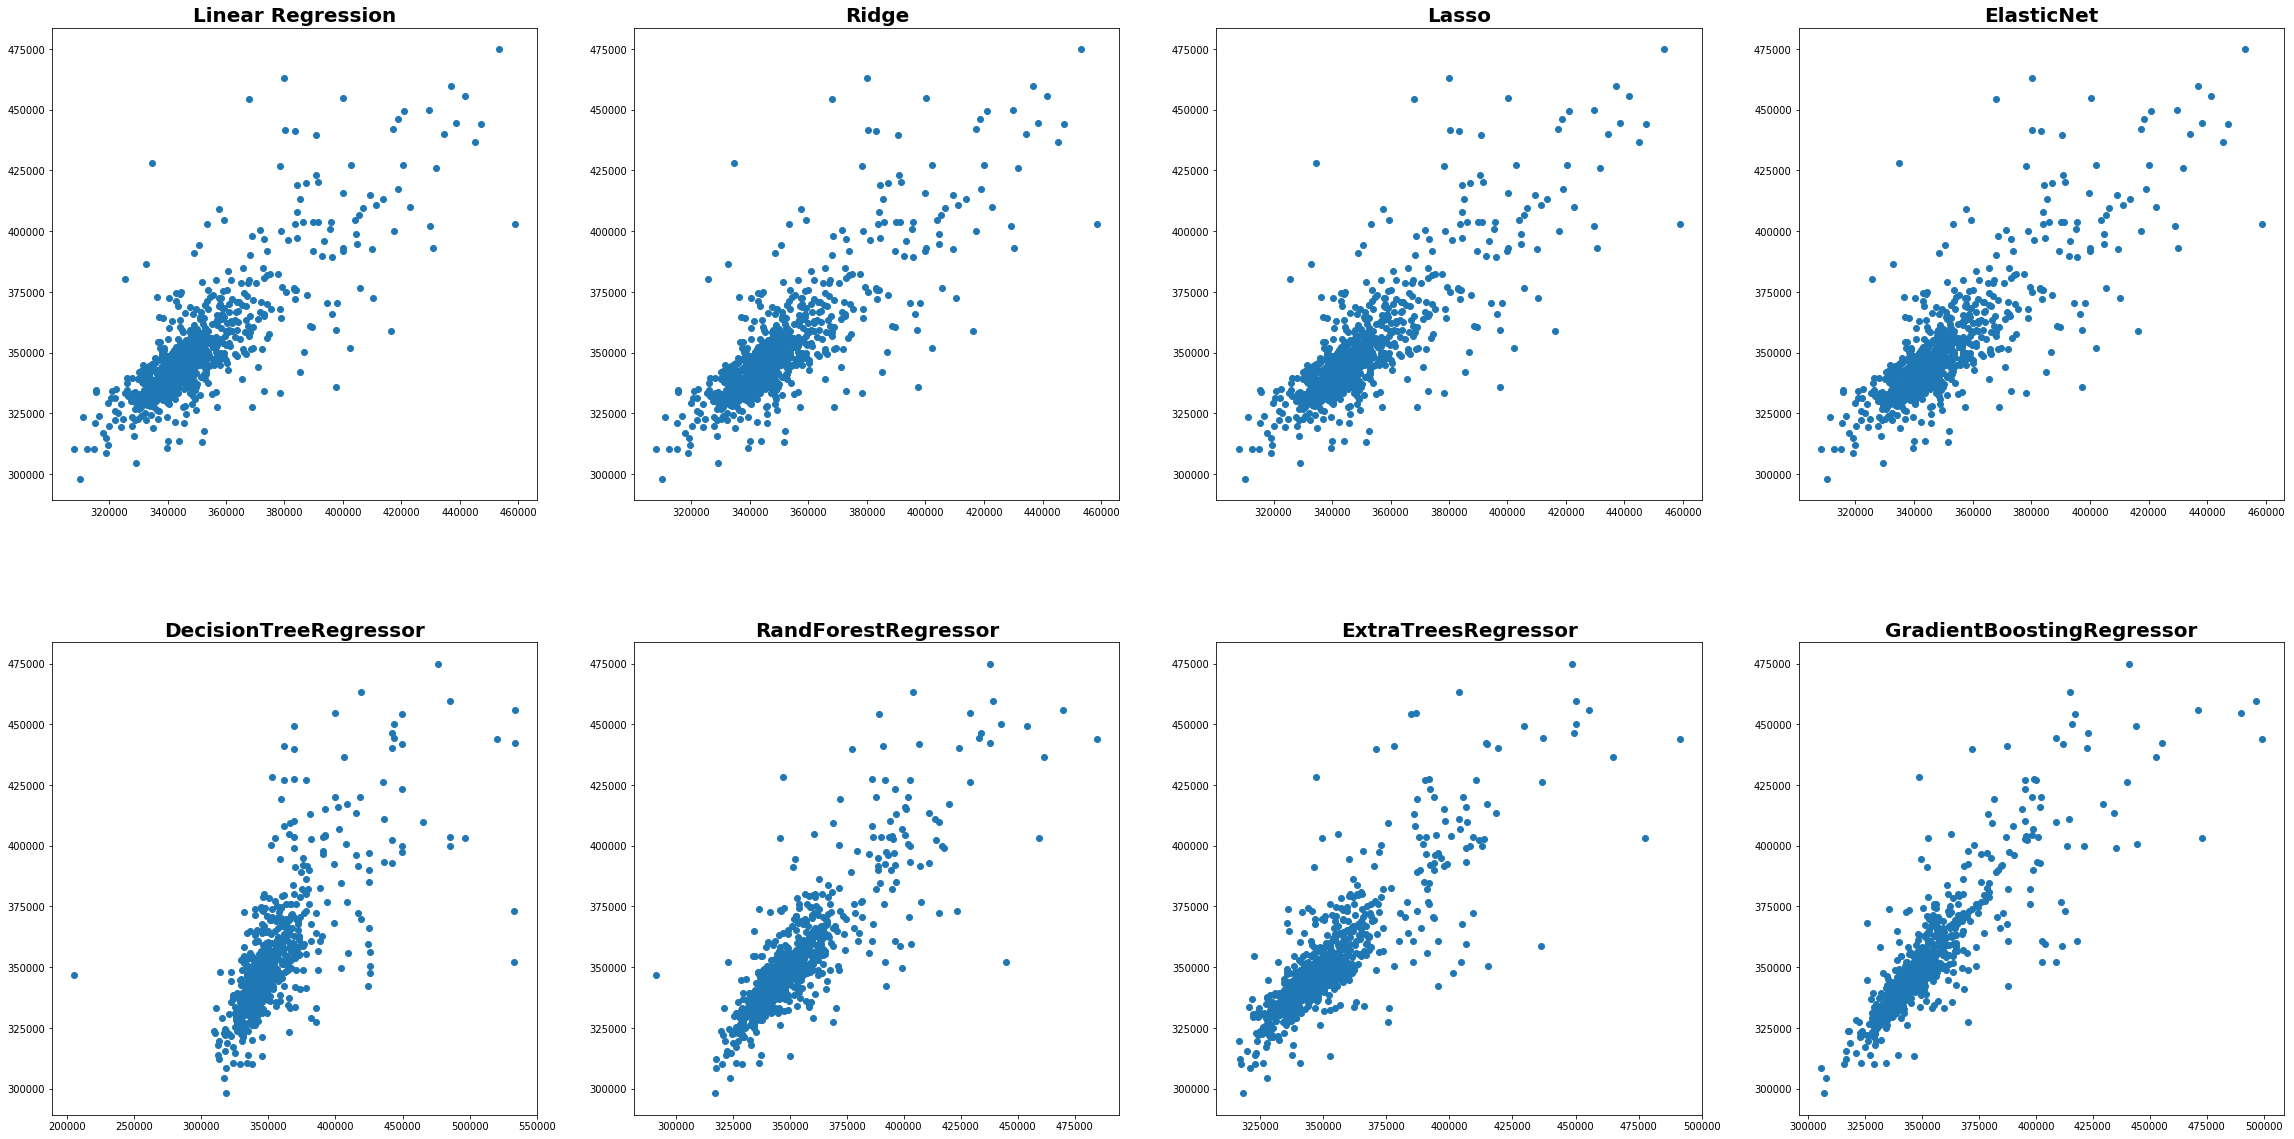

In [4]:
f, axarr = plt.subplots(2, 4)
f.set_size_inches(40, 20)
axarr[0,0].scatter(predictions[0],y_test)
axarr[0,0].set_title("Linear Regression", fontsize=20, fontweight='bold')
axarr[0,1].scatter(predictions[1],y_test)
axarr[0,1].set_title("Ridge", fontsize=20, fontweight='bold')
axarr[0,2].scatter(predictions[2],y_test)
axarr[0,2].set_title("Lasso", fontsize=20, fontweight='bold')
axarr[0,3].scatter(predictions[3],y_test)
axarr[0,3].set_title("ElasticNet", fontsize=20, fontweight='bold')
axarr[1,0].scatter(predictions[4],y_test)
axarr[1,0].set_title("DecisionTreeRegressor", fontsize=20, fontweight='bold')
axarr[1,1].scatter(predictions[5],y_test)
axarr[1,1].set_title("RandForestRegressor", fontsize=20, fontweight='bold')
axarr[1,2].scatter(predictions[6],y_test)
axarr[1,2].set_title("ExtraTreesRegressor", fontsize=20, fontweight='bold')
axarr[1,3].scatter(predictions[7],y_test)
axarr[1,3].set_title("GradientBoostingRegressor", fontsize=20, fontweight='bold')
f.subplots_adjust(hspace=0.3)

# Export Tree Data for visualization

In [5]:
dot_data = tree.export_graphviz(models[4], out_file='tree.dot') 

# GLM Coefficients

In [6]:
coef_df = pd.DataFrame()


var_names = {0:'jaarfractie',1:'bevolking',2:'summer-vac',3:'tem>20',4:'verd De Bilt',5:'zaagtand',6:'weekdag1',7:'weekdag2',8:'weekdag3',9:'weekdag4',10:'weekdag5',11:'weekdag6'}

model_names = ['Linear Regression','Ridge','Lasso','Elastic-net']

for i in range(0,4):
    if(model_names[i] == 'Lasso' or model_names[i] == 'Elastic-net'):
       mod = models[i].coef_
    else:
       mod = models[i].coef_[0]
    coef_df[model_names[i]] = mod

coef_df = coef_df.rename(index=var_names)

coef_df

,Linear Regression,Ridge,Lasso,Elastic-net
jaarfractie,4484.810698,4197.451678,4457.687496,4081.321399
bevolking,0.221519,0.221858,0.221555,0.221998
summer-vac,-10893.291641,-11017.760722,-10889.873038,-11066.646572
tem>20,8640.020171,8633.775219,8638.876151,8631.142528
verd De Bilt,1318.018617,1320.099017,1317.975407,1320.886839
zaagtand,31981.764261,31415.294294,31950.425708,31185.068263
weekdag1,-17686.029558,-17359.798246,-17636.616247,-17227.620043
weekdag2,-4065.774161,-3809.327192,-4016.818403,-3706.173935
weekdag3,-9441.078839,-9157.716476,-9391.265496,-9043.392348
weekdag4,-4364.361913,-4110.552209,-4315.412069,-4008.483814


# Tree Models Feature Importance

In [7]:
feature_df = pd.DataFrame()


var_names = {0:'jaarfractie',1:'bevolking',2:'summer-vac',3:'tem>20',4:'verd De Bilt',5:'zaagtand',6:'weekdag1',7:'weekdag2',8:'weekdag3',9:'weekdag4',10:'weekdag5',11:'weekdag6'}

model_names = ['Decision Tree','Random Forest','Extra Tree','Gradient Boosting']

for i in range(4,8):
    feature_df[model_names[i-4]] = models[i].feature_importances_

feature_df = feature_df.rename(index=var_names)

feature_df

,Decision Tree,Random Forest,Extra Tree,Gradient Boosting
jaarfractie,0.108986,0.101815,0.098080,0.104552
bevolking,0.118305,0.103617,0.102154,0.174426
summer-vac,0.002023,0.002798,0.023905,0.001463
tem>20,0.471779,0.487535,0.453221,0.323004
verd De Bilt,0.025625,0.039395,0.045698,0.025060
zaagtand,0.180479,0.198470,0.171257,0.276760
weekdag1,0.026705,0.023273,0.027850,0.059585
weekdag2,0.029739,0.016697,0.022520,0.003364
weekdag3,0.013893,0.006853,0.013265,0.009022
weekdag4,0.007681,0.005763,0.011852,0.002098
